[View in Colaboratory](https://colab.research.google.com/github/Moons08/TIL/blob/master/06_GAN_2.ipynb)

# DC GAN
- 생성기와 분별기가 서로 경쟁하며 트레이닝
- 구현 참조 (https://github.com/eriklindernoren/Keras-GAN)

In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

## Generator

In [0]:
generator_ = Sequential()
generator_.add(Dense(128 * 7 * 7, activation="relu", input_shape=(100,)))
generator_.add(Reshape((7, 7, 128)))
generator_.add(BatchNormalization(momentum=0.8))
generator_.add(UpSampling2D())
generator_.add(Conv2D(128, kernel_size=3, padding="same"))
generator_.add(Activation("relu"))
generator_.add(BatchNormalization(momentum=0.8)) 
generator_.add(UpSampling2D())
generator_.add(Conv2D(64, kernel_size=3, padding="same"))
generator_.add(Activation("relu"))
generator_.add(BatchNormalization(momentum=0.8))
generator_.add(Conv2D(1, kernel_size=3, padding="same"))
generator_.add(Activation("tanh"))

In [0]:
noise_input = Input(shape=(100,), name="noise_input")
generator = Model(noise_input, generator_(noise_input), name="generator")

In [5]:
generator_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
__________

generator_를 하나의 레이어로 취급

In [6]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise_input (InputLayer)     (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         856705    
Total params: 856,705
Trainable params: 856,065
Non-trainable params: 640
_________________________________________________________________


In [0]:
optimizer = Adam(0.0002, 0.5)

In [0]:
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

In [9]:
import numpy as np

noise_data = np.random.normal(0, 1, (32, 100))
generated_images = 0.5 * generator.predict(noise_data) + 0.5
generated_images.shape

(32, 28, 28, 1)

In [0]:
import matplotlib.pyplot as plt

def show_images(generated_images, n=4, m=8, figsize=(9, 5)):
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1)
            ax.imshow(generated_images[k][:, :, 0], cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.show()

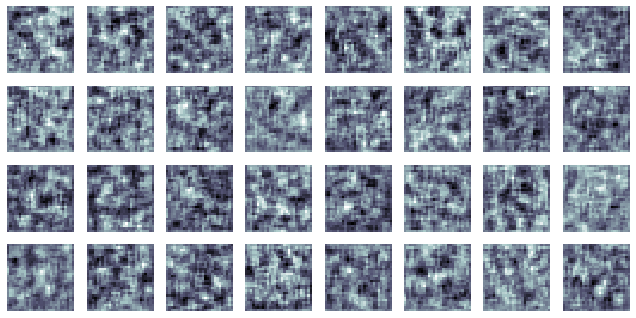

In [11]:
show_images(generated_images) # 학습 전 생성모델이 만든 이미지

## Discriminator

In [0]:
discriminator_ = Sequential()

discriminator_.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding="same"))
discriminator_.add(LeakyReLU(alpha=0.2))
discriminator_.add(Dropout(0.25))
discriminator_.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator_.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator_.add(LeakyReLU(alpha=0.2))
discriminator_.add(Dropout(0.25))
discriminator_.add(BatchNormalization(momentum=0.8))
discriminator_.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator_.add(LeakyReLU(alpha=0.2))
discriminator_.add(Dropout(0.25))
discriminator_.add(BatchNormalization(momentum=0.8))
discriminator_.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator_.add(LeakyReLU(alpha=0.2))
discriminator_.add(Dropout(0.25))
discriminator_.add(Flatten())
discriminator_.add(Dense(1, activation='sigmoid'))

image_input = Input(shape=(28, 28, 1), name="image_input")

discriminator = Model(image_input, discriminator_(image_input), name="discriminator")

In [13]:
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
__________

In [14]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 392705    
Total params: 392,705
Trainable params: 392,321
Non-trainable params: 384
_________________________________________________________________


## Combined Model
Generator, discriminator 를 직렬 연결

In [0]:
noise_input2 = Input(shape=(100,), name="noise_input2")
combined = Model(noise_input2, discriminator(generator(noise_input2)))

In [16]:
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise_input2 (InputLayer)    (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         856705    
_________________________________________________________________
discriminator (Model)        (None, 1)                 392705    
Total params: 1,249,410
Trainable params: 1,248,386
Non-trainable params: 1,024
_________________________________________________________________


In [0]:
combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Sample data

In [0]:
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

In [0]:
batch_size = 64
half_batch = int(batch_size / 2)

In [0]:
def train(epochs, print_step=10):
    history = []
    for epoch in range(epochs):

        # discriminator 트레이닝 단계
        #######################################################################3
        
        # 데이터 절반은 실제 이미지, 절반은 generator가 생성한 가짜 이미지
        real_images = X_train[np.random.randint(0, X_train.shape[0], half_batch)]
        y_real = np.ones((half_batch, 1))
        generated_images = generator.predict(np.random.normal(0, 1, (half_batch, 100)))
        y_generated = np.zeros((half_batch, 1))
        
        # discriminator가 실제 이미지와 가짜 이미지를 구별하도록 discriminator를 트레이닝
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_images, y_real)
        d_loss_fake = discriminator.train_on_batch(generated_images, y_generated)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # generator 트레이닝 단계
        #######################################################################3
        
        # 전부 generator가 생성한 가짜 이미지를 사용. 
        # discriminator가 구별하지 못하도록 generator를 트레이닝
        noise = np.random.normal(0, 1, (batch_size, 100))
        discriminator.trainable = False
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # 기록
        record = (epoch, d_loss[0], 100 * d_loss[1], g_loss[0], 100 * g_loss[1])
        history.append(record)
        if epoch % print_step == 0:
            print("%5d [D loss: %.3f, acc.: %.2f%%] [G loss: %.3f, acc.: %.2f%%]" % record)

In [24]:
%%time
history100 = train(100)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


    0 [D loss: 0.614, acc.: 68.75%] [G loss: 0.960, acc.: 45.31%]
   10 [D loss: 0.938, acc.: 53.12%] [G loss: 0.382, acc.: 89.06%]
   20 [D loss: 1.121, acc.: 50.00%] [G loss: 0.317, acc.: 92.19%]
   30 [D loss: 1.193, acc.: 50.00%] [G loss: 0.332, acc.: 95.31%]
   40 [D loss: 1.137, acc.: 50.00%] [G loss: 0.415, acc.: 81.25%]
   50 [D loss: 1.034, acc.: 50.00%] [G loss: 0.288, acc.: 93.75%]
   60 [D loss: 1.246, acc.: 50.00%] [G loss: 0.342, acc.: 93.75%]
   70 [D loss: 1.153, acc.: 50.00%] [G loss: 0.349, acc.: 89.06%]
   80 [D loss: 1.185, acc.: 51.56%] [G loss: 0.266, acc.: 96.88%]
   90 [D loss: 1.222, acc.: 50.00%] [G loss: 0.297, acc.: 96.88%]
CPU times: user 11.2 s, sys: 4.25 s, total: 15.5 s
Wall time: 12 s


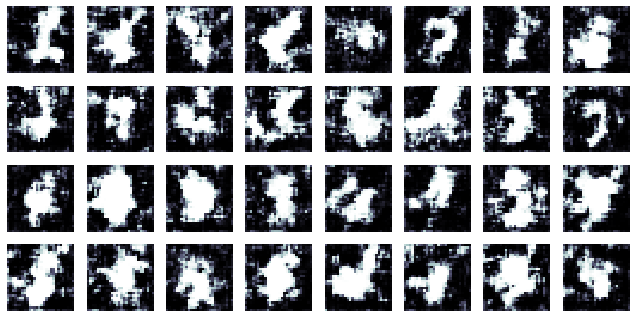

In [25]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [0]:
from keras.models import load_model

def save_models(epoch):
    generator.save("dcgan_generator_{}.hdf5".format(epoch))
    discriminator.save("dcgan_discriminator_{}.hdf5".format(epoch))
    combined.save("dcgan_combined_{}.hdf5".format(epoch))

In [27]:
%%time
history1000 = train(1000, 100)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


    0 [D loss: 1.065, acc.: 50.00%] [G loss: 0.350, acc.: 95.31%]
  100 [D loss: 1.236, acc.: 51.56%] [G loss: 0.258, acc.: 98.44%]
  200 [D loss: 1.229, acc.: 50.00%] [G loss: 0.250, acc.: 98.44%]
  300 [D loss: 1.147, acc.: 50.00%] [G loss: 0.258, acc.: 98.44%]
  400 [D loss: 1.229, acc.: 50.00%] [G loss: 0.215, acc.: 100.00%]
  500 [D loss: 1.149, acc.: 50.00%] [G loss: 0.214, acc.: 100.00%]
  600 [D loss: 1.046, acc.: 50.00%] [G loss: 0.221, acc.: 100.00%]
  700 [D loss: 1.114, acc.: 50.00%] [G loss: 0.237, acc.: 100.00%]
  800 [D loss: 1.087, acc.: 50.00%] [G loss: 0.234, acc.: 100.00%]
  900 [D loss: 1.076, acc.: 50.00%] [G loss: 0.215, acc.: 98.44%]
CPU times: user 1min 40s, sys: 39.1 s, total: 2min 20s
Wall time: 1min 47s


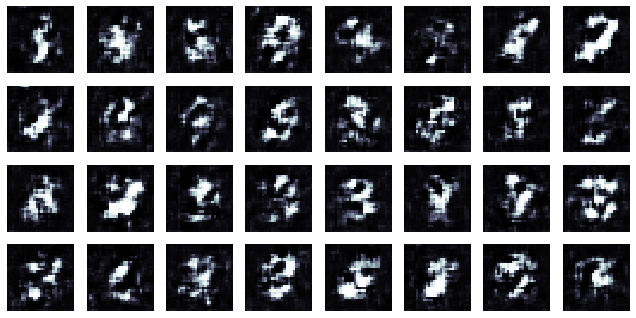

In [28]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [30]:
%%time
history5000 = train(4000, 1000)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


    0 [D loss: 1.151, acc.: 50.00%] [G loss: 0.211, acc.: 100.00%]
 1000 [D loss: 1.168, acc.: 50.00%] [G loss: 0.247, acc.: 98.44%]
 2000 [D loss: 1.110, acc.: 50.00%] [G loss: 0.236, acc.: 95.31%]
 3000 [D loss: 1.088, acc.: 50.00%] [G loss: 0.323, acc.: 95.31%]
CPU times: user 6min 50s, sys: 2min 38s, total: 9min 29s
Wall time: 7min 16s


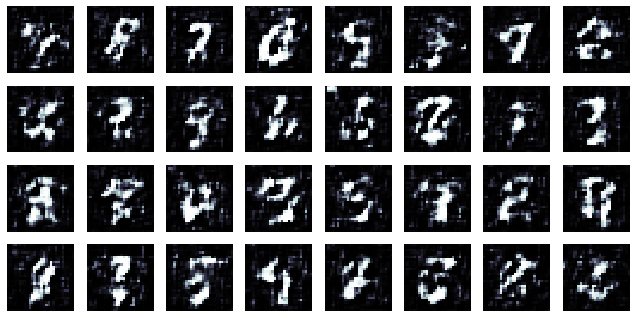

In [31]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [32]:
%%time
history10000 = train(5000, 900)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


    0 [D loss: 1.243, acc.: 50.00%] [G loss: 0.314, acc.: 89.06%]
  900 [D loss: 1.243, acc.: 51.56%] [G loss: 0.378, acc.: 84.38%]
 1800 [D loss: 1.107, acc.: 48.44%] [G loss: 0.351, acc.: 89.06%]
 2700 [D loss: 1.201, acc.: 50.00%] [G loss: 0.420, acc.: 82.81%]
 3600 [D loss: 1.008, acc.: 53.12%] [G loss: 0.351, acc.: 89.06%]
 4500 [D loss: 1.278, acc.: 48.44%] [G loss: 0.510, acc.: 79.69%]
CPU times: user 8min 23s, sys: 3min 11s, total: 11min 34s
Wall time: 8min 45s


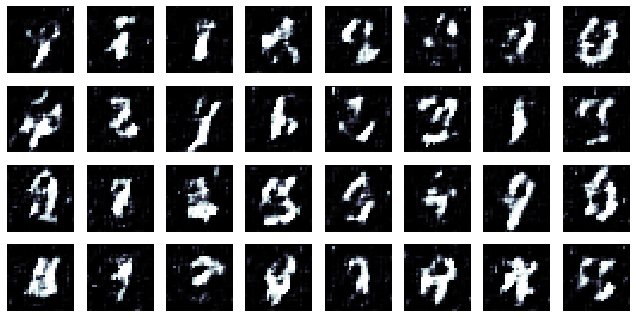

In [33]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [34]:
%%time
history20000 = train(10000, 500)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


    0 [D loss: 1.149, acc.: 56.25%] [G loss: 0.426, acc.: 76.56%]
  500 [D loss: 0.953, acc.: 51.56%] [G loss: 0.437, acc.: 78.12%]
 1000 [D loss: 1.393, acc.: 48.44%] [G loss: 0.523, acc.: 71.88%]
 1500 [D loss: 1.259, acc.: 54.69%] [G loss: 0.426, acc.: 79.69%]
 2000 [D loss: 1.449, acc.: 48.44%] [G loss: 0.505, acc.: 78.12%]
 2500 [D loss: 1.366, acc.: 51.56%] [G loss: 0.494, acc.: 78.12%]
 3000 [D loss: 1.192, acc.: 54.69%] [G loss: 0.448, acc.: 79.69%]
 3500 [D loss: 1.436, acc.: 42.19%] [G loss: 0.360, acc.: 87.50%]
 4000 [D loss: 1.199, acc.: 46.88%] [G loss: 0.439, acc.: 81.25%]
 4500 [D loss: 1.188, acc.: 56.25%] [G loss: 0.480, acc.: 81.25%]
 5000 [D loss: 1.398, acc.: 54.69%] [G loss: 0.387, acc.: 85.94%]
 5500 [D loss: 1.297, acc.: 48.44%] [G loss: 0.587, acc.: 70.31%]
 6000 [D loss: 1.297, acc.: 56.25%] [G loss: 0.509, acc.: 82.81%]
 6500 [D loss: 1.222, acc.: 53.12%] [G loss: 0.416, acc.: 76.56%]
 7000 [D loss: 1.834, acc.: 45.31%] [G loss: 0.609, acc.: 68.75%]
 7500 [D l

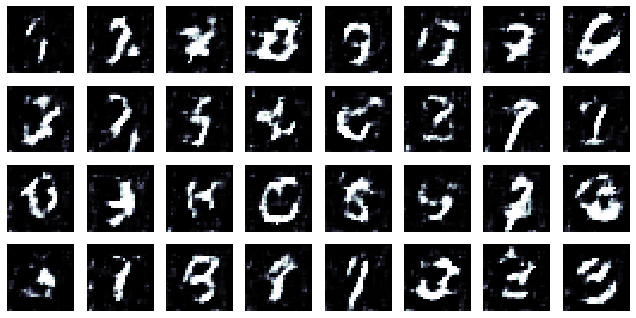

In [35]:
 show_images(0.5 * generator.predict(noise_data) + 0.5)